In [1]:
%matplotlib inline
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import vincenty

In [2]:
#parse_dates = ['pickup_datetime', 'dropoff_datetime']
parse_dates=[]
train = pd.read_csv("data/train.csv", parse_dates=['pickup_datetime', 'dropoff_datetime'])
test = pd.read_csv("data/test.csv", parse_dates=['pickup_datetime'])

In [3]:
print(" Train size : %s" % str(train.shape))
print(" Test size : %s" % str(test.shape))

 Train size : (1458644, 11)
 Test size : (625134, 9)


In [4]:
print("Column names %s " % str(train.columns.values))


#Description of the column from https://www.kaggle.com/c/nyc-taxi-trip-duration : 

#id - a unique identifier for each trip
#vendor_id - a code indicating the provider associated with the trip record
#pickup_datetime - date and time when the meter was engaged
#dropoff_datetime - date and time when the meter was disengaged
#passenger_count - the number of passengers in the vehicle (driver entered value)
#pickup_longitude - the longitude where the meter was engaged
#pickup_latitude - the latitude where the meter was engaged
#dropoff_longitude - the longitude where the meter was disengaged
#dropoff_latitude - the latitude where the meter was disengaged
#store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to
#the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
#trip_duration - duration of the trip in seconds

Column names ['id' 'vendor_id' 'pickup_datetime' 'dropoff_datetime' 'passenger_count'
 'pickup_longitude' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'store_and_fwd_flag' 'trip_duration'] 


In [5]:
#Create some distance related columns
def compute_distance(x):
    #'pickup_longitude' 'pickup_latitude' 'dropoff_longitude' 'dropoff_latitude'
    lat_1 = x["pickup_latitude"]
    lat_2 = x["dropoff_latitude"]
    long_1 = x["pickup_longitude"]
    long_2 = x["dropoff_longitude"]
    
    return vincenty((lat_1, long_1), (lat_2, long_2)).miles

#Compute bearing from https://gist.github.com/jeromer/2005586
def calculate_initial_compass_bearing(pointA, pointB):
    
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

def compute_bearing(x):
    #'pickup_longitude' 'pickup_latitude' 'dropoff_longitude' 'dropoff_latitude'
    lat_1 = x["pickup_latitude"]
    lat_2 = x["dropoff_latitude"]
    long_1 = x["pickup_longitude"]
    long_2 = x["dropoff_longitude"]
    
    return calculate_initial_compass_bearing((lat_1, long_1), (lat_2, long_2))

In [6]:
#create date related columns 
train["day_of_week"] = train.pickup_datetime.dt.dayofweek
train["month"] = train.pickup_datetime.dt.month
train["day_of_month"] = train.pickup_datetime.dt.day
train["day_of_year"] = train.pickup_datetime.dt.dayofyear
train["hour"] = train.pickup_datetime.dt.hour
train["minute"] = train.pickup_datetime.dt.minute

In [7]:
train["distance"] = train.apply(lambda x: compute_distance(x), axis=1)
train["bearing"] = train.apply(lambda x: compute_bearing(x), axis=1)

In [8]:
print(train[["pickup_datetime", "day_of_week", "day_of_month", "month", "day_of_year", "hour", "minute"]].head(10))

      pickup_datetime  day_of_week  day_of_month  month  day_of_year  hour  \
0 2016-03-14 17:24:55            0            14      3           74    17   
1 2016-06-12 00:43:35            6            12      6          164     0   
2 2016-01-19 11:35:24            1            19      1           19    11   
3 2016-04-06 19:32:31            2             6      4           97    19   
4 2016-03-26 13:30:55            5            26      3           86    13   
5 2016-01-30 22:01:40            5            30      1           30    22   
6 2016-06-17 22:34:59            4            17      6          169    22   
7 2016-05-21 07:54:58            5            21      5          142     7   
8 2016-05-27 23:12:23            4            27      5          148    23   
9 2016-03-10 21:45:01            3            10      3           70    21   

   minute  
0      24  
1      43  
2      35  
3      32  
4      30  
5       1  
6      34  
7      54  
8      12  
9      45  


In [9]:
print("Train dates are between %s and %s " %(min(train.pickup_datetime), max(train.pickup_datetime)))

Train dates are between 2016-01-01 00:00:17 and 2016-06-30 23:59:39 


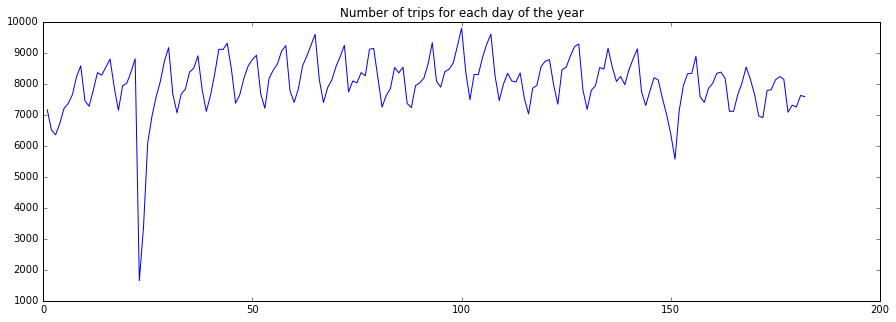

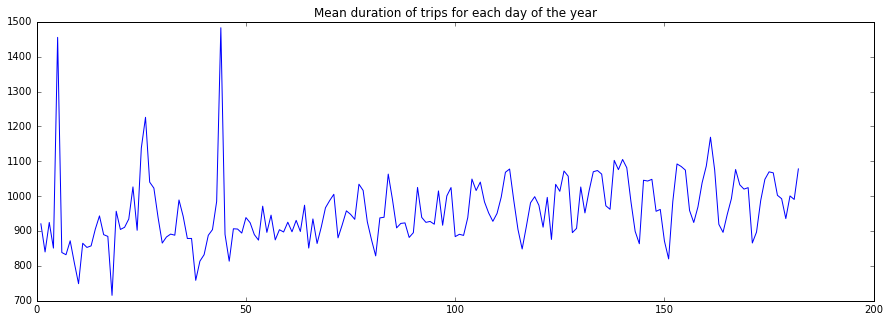

In [10]:
count_day_year_df = train[["day_of_year", "trip_duration"]].groupby(["day_of_year"] , as_index = False).count()
duration_day_year_df = train[["day_of_year", "trip_duration"]].groupby(["day_of_year"] , as_index = False).mean()

plt.figure(figsize=(15,5))
plt.plot(count_day_year_df["day_of_year"], count_day_year_df["trip_duration"])
plt.title('Number of trips for each day of the year')
plt.show()


plt.figure(figsize=(15,5))
plt.plot(duration_day_year_df["day_of_year"], duration_day_year_df["trip_duration"])
plt.title('Mean duration of trips for each day of the year')
plt.show()

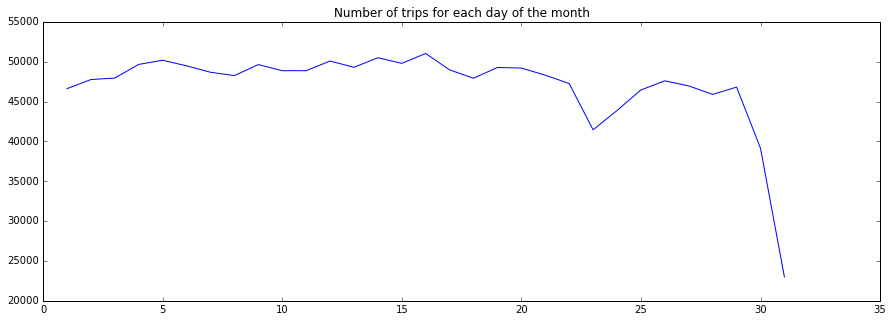

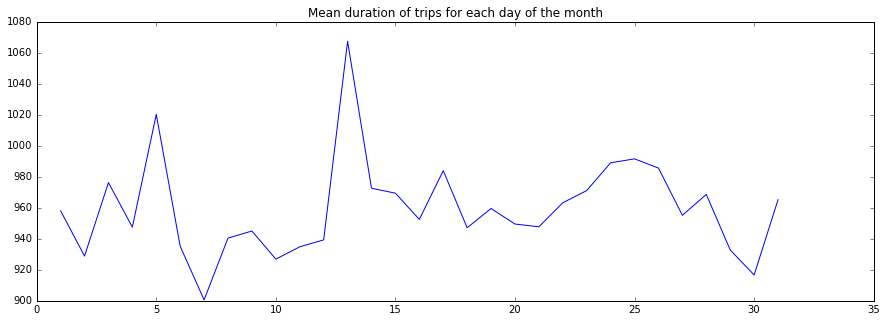

In [11]:
count_day_month_df = train[["day_of_month", "trip_duration"]].groupby(["day_of_month"] , as_index = False).count()
duration_day_month_df = train[["day_of_month", "trip_duration"]].groupby(["day_of_month"] , as_index = False).mean()
plt.figure(figsize=(15,5))
plt.plot(count_day_month_df["day_of_month"], count_day_month_df["trip_duration"])
plt.title('Number of trips for each day of the month')
plt.show()
plt.figure(figsize=(15,5))
plt.plot(duration_day_month_df["day_of_month"], duration_day_month_df["trip_duration"])
plt.title('Mean duration of trips for each day of the month')
plt.show()

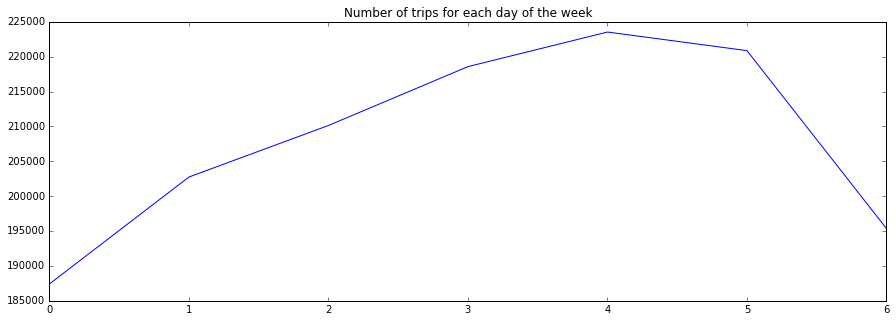

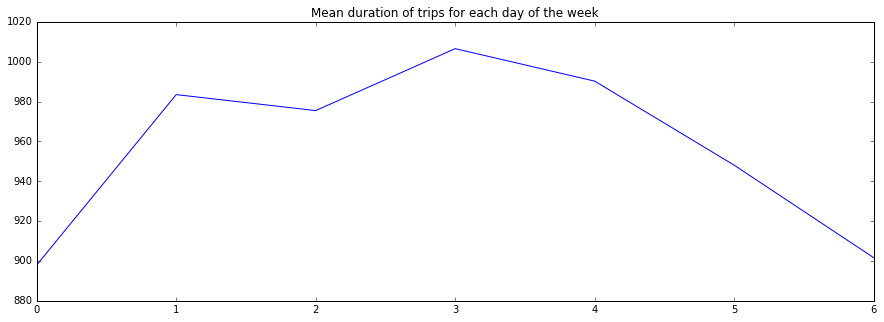

In [12]:
count_day_week_df = train[["day_of_week", "trip_duration"]].groupby(["day_of_week"] , as_index = False).count()
duration_day_week_df = train[["day_of_week", "trip_duration"]].groupby(["day_of_week"] , as_index = False).mean()
plt.figure(figsize=(15,5))
plt.plot(count_day_week_df["day_of_week"], count_day_week_df["trip_duration"])
plt.title('Number of trips for each day of the week')
plt.show()
plt.figure(figsize=(15,5))
plt.plot(duration_day_week_df["day_of_week"], duration_day_week_df["trip_duration"])
plt.title('Mean duration of trips for each day of the week')
plt.show()

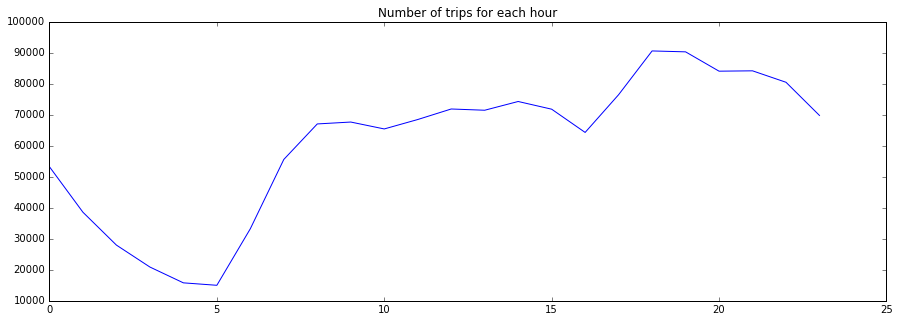

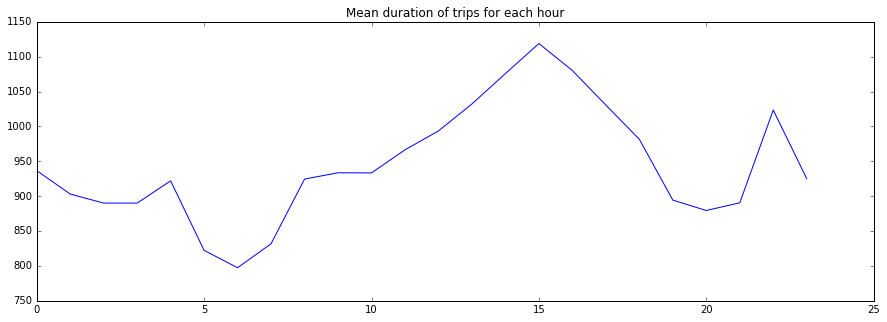

In [13]:
count_hour_df = train[["hour", "trip_duration"]].groupby(["hour"] , as_index = False).count()
duration_hour_df = train[["hour", "trip_duration"]].groupby(["hour"] , as_index = False).mean()
plt.figure(figsize=(15,5))
plt.plot(count_hour_df["hour"], count_hour_df["trip_duration"])
plt.title('Number of trips for each hour')
plt.show()
plt.figure(figsize=(15,5))
plt.plot(duration_hour_df["hour"], duration_hour_df["trip_duration"])
plt.title('Mean duration of trips for each hour')
plt.show()

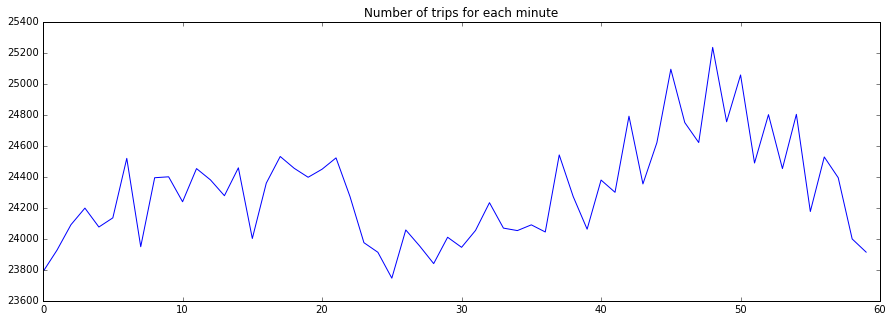

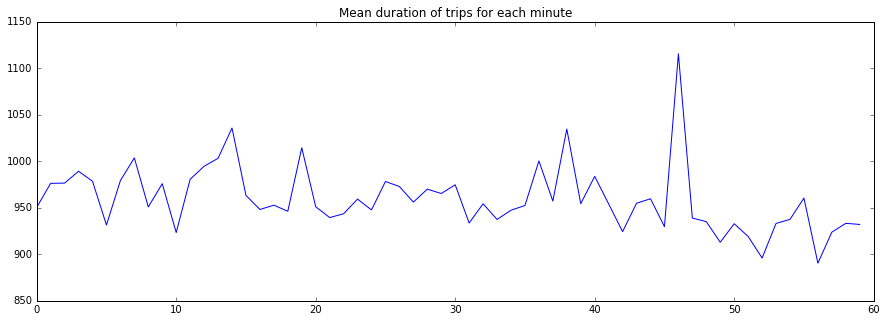

In [14]:
count_minute_df = train[["minute", "trip_duration"]].groupby(["minute"] , as_index = False).count()
duration_minute_df = train[["minute", "trip_duration"]].groupby(["minute"] , as_index = False).mean()
plt.figure(figsize=(15,5))
plt.plot(count_minute_df["minute"], count_minute_df["trip_duration"])
plt.title('Number of trips for each minute')
plt.show()
plt.figure(figsize=(15,5))
plt.plot(duration_minute_df["minute"], duration_minute_df["trip_duration"])
plt.title('Mean duration of trips for each minute')
plt.show()

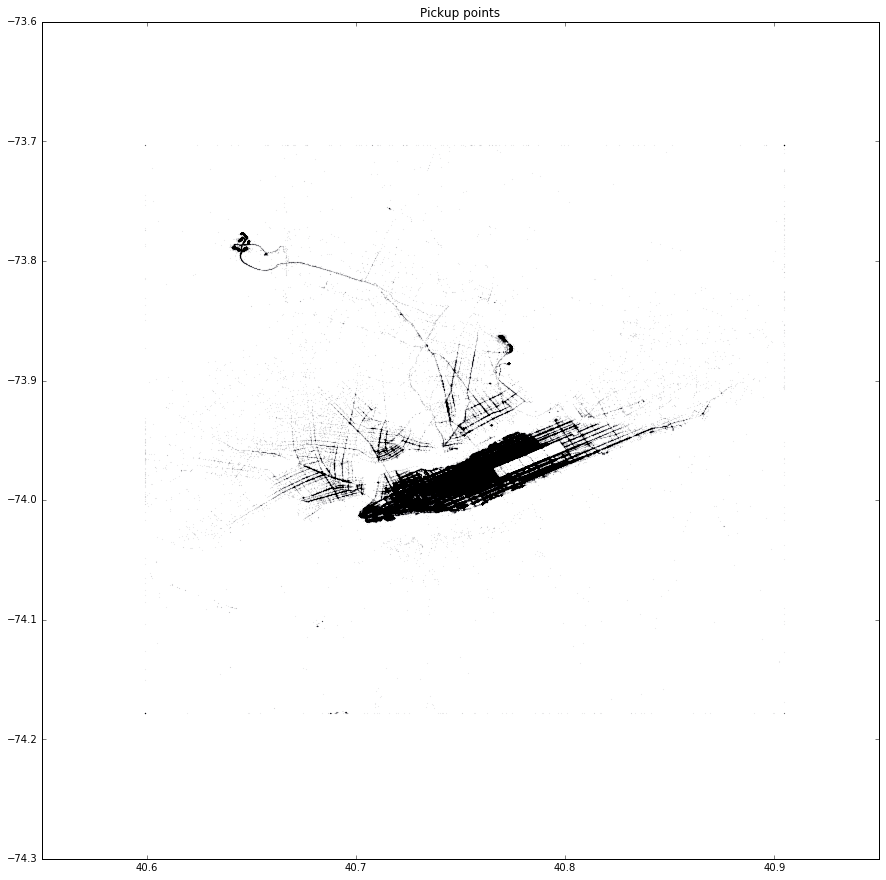

In [21]:
q_lat_001 = train["pickup_latitude"].quantile(0.0001)
q_lat_099 = train["pickup_latitude"].quantile(0.9999)

q_long_001 = train["pickup_longitude"].quantile(0.0001)
q_long_099 = train["pickup_longitude"].quantile(0.9999)

plt.figure(figsize=(15,15))
plt.scatter(train["pickup_latitude"].clip(q_lat_001, q_lat_099), 
            train["pickup_longitude"].clip(q_long_001, q_long_099),
            s=0.01, alpha=0.3)
plt.title('Pickup points')
plt.show()